### Blurring : Generate A (represent as T)

[[0.17857143 0.16157811 0.11970001 ... 0.         0.         0.        ]
 [0.16157811 0.17857143 0.16157811 ... 0.         0.         0.        ]
 [0.11970001 0.16157811 0.17857143 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.17857143 0.16157811 0.11970001]
 [0.         0.         0.         ... 0.16157811 0.17857143 0.16157811]
 [0.         0.         0.         ... 0.11970001 0.16157811 0.17857143]]


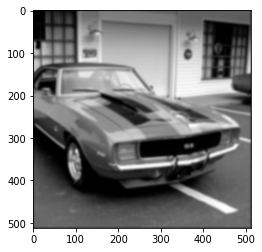

In [40]:
import numpy as np
import scipy.io
from PIL import Image
import time
from matplotlib import image
from matplotlib import pyplot as plt
from scipy.linalg import lu_factor, lu_solve
from sklearn.datasets import load_wine


def image_process(L):
    im = Image.open(L) 
    im = im.convert('L')
    img = np.array(im)
    img = img.astype(np.float64) / 256
    return img

        
def toeplitz(i,T,img):
    t = []
    for k in range(T.shape[1]):
        # t.append(np.exp(-0.1*(i-k)**2))
        T[i,k] = 1/5.6*np.exp(-0.1*(i-k)**2)
    # c = 1/sum(t)
    # for j in range(T.shape[0]):
        # T[i,j] = 1/5.6*t[j]
    return T


L = "D:\\My Code\\codes\\test_images\\512_512_car_02.png"


img = image_process(L)

T = np.zeros([img.shape[0],img.shape[1]])

for i in range(img.shape[0]):
    T = toeplitz(i,T,img)

print(T)
B = T @ img @ T.T

plt.imshow(B,cmap = 'gray')
plt.show()


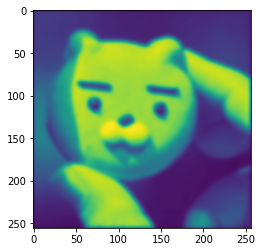

In [7]:
delta = 0.1

def T_form(n):
    d = [(2+delta)/(4+delta)]*n
    t = np.diag(d)
    t1 = np.diag([1/(4+delta)]*(n-1),1)
    t2 = np.diag([1/(4+delta)]*(n-1),-1)
    T = t + t1 + t2
    return T
B = T @ img @ T.T
plt.imshow(B)
plt.show()

### Phase I

In [50]:
import numpy as np
# This program is to transform A into bidiagonal form utilizing householder

def householder(b_r,length): # b is a vector that we want to only preserve b1, length is the longtitude of b_r
    beta = np.linalg.norm(b_r)
    v = np.array([0.0 for i in range(length)])
    if (b_r[1:]==0).all():
        return np.identity(length), b_r[0]
    v[0] = (np.abs(b_r[0])+beta)*np.sign(b_r[0])
    v[1:] = b_r[1:]
    H = np.identity(length)-(2/(np.inner(v,v)))*np.outer(v,v.T)
    #print(H@b_r)
    return H,-1*np.sign(b_r[0])*beta  #np.identity(length)-(2/(np.linalg.norm(b_r)**2))*np.outer(b_r,b_r)

def Bidiagonalization(A):
    row,col=np.shape(A)
    diff = row-col #find shape
    H_all_U = np.identity(row)
    H_all_V = np.identity(col)
    if diff >= -1 :
        for i in range(col-2):
            H1 = np.identity(row)
            H2 = np.identity(col)
            H_U, entry_u = householder(A[i:,i],row-i) #gen U
            A[i,i] = entry_u
            A[i+1:,i] = 0
            A[i:,i+1:] = np.matmul(H_U,A[i:,i+1:]) #update A utilizing U  列+1
            H1[i:,i:] = H_U
            H_all_U = H1@H_all_U
            #print(np.round(A,4))
            H_V, entry_v = householder(A[i,i+1:],col-i-1) # gen V
            A[i,i+1] = entry_v
            A[i,i+2:] = 0
            A[i+1:,i+1:] = A[i+1:,i+1:]@H_V #行-1
            H2[i+1:,i+1:] = H_V
            H_all_V = H_all_V@H2
            #print(np.round(A,4))
        if diff == -1:
            return A,H_all_U,H_all_V
        elif diff == 0:
            H1 = np.identity(row)
            H_U, entry_u = householder(A[row-2:,col-2],2)
            A[row-2,row-2] = entry_u
            A[row-1,row-2] = 0.0
            A[row-2:,row-1:] = H_U@A[row-2:,row-1:] #lie-1
            H1[row-2:,row-2:] = H_U
            H_all_U = H1@H_all_U
            return A,H_all_U,H_all_V
        else:
            H1 = np.identity(row)
            H_U, entry_u = householder(A[col-2:,col-2],diff+2)
            A[col-2,col-2] = entry_u
            A[col-1:,col-2] = 0.0
            #print(A)
            #print(A[col-1:,col-1],H_U)
            A[col-2:,col-1:] = H_U@A[col-2:,col-1:] #lie-1
            H1[col-2:,col-2:] = H_U
            H_all_U = H1@H_all_U
            H1 = np.identity(row)
            H_U, entry_u = householder(A[col-1:,col-1],diff+1)
            A[col-1,col-1] = entry_u
            A[col:,col-1] = 0.0
            A[col-1:,col] = H_U@A[col-1:,col] #lie-1
            H1[col-1:,col-1:] = H_U
            H_all_U = H1@H_all_U
            return A,H_all_U,H_all_V
    else:
        for i in range(row-1):
            H1 = np.identity(row)
            H2 = np.identity(col)
            H_U, entry_u = householder(A[i:,i],row-i) #gen U
            A[i,i] = entry_u
            A[i+1:,i] = 0
            A[i:,i+1:] = np.matmul(H_U,A[i:,i+1:]) #update A utilizing U  列-1
            #print(np.round(A,4))
            H1[i:,i:] = H_U
            H_all_U = H1@H_all_U
            H_V, entry_v = householder(A[i,i+1:],col-i-1) # gen V
            A[i,i+1] = entry_v
            A[i,i+2:] = 0
            A[i+1:,i+1:] = A[i+1:,i+1:]@H_V #行-1
            #print(np.round(A,4))
            H2[i+1:,i+1:] = H_V
            H_all_V = H_all_V@H2
        H2 = np.identity(col)
        H_V, entry_v = householder(A[row-1,row:],2)
        A[row-1,row:] = A[row-1,row:]@H_V
        H2[col-2:,col-2:] = H_V
        H_all_V = H_all_V@H2
        return A,H_all_U,H_all_V #return result, U,V(no need to do the transpose)

#A=np.random.rand(512,512)
'''
A = np.array([
    [1.0,3.0,2.5],
    [2.3,4.5,2.5],
    [2.4,2.5,2.6]
])
'''
#B = np.array(A)
#print(B)
#result,U,V = Bidiagonalization(A)
#print(np.round(result,4))
#print(np.round(U.T@result@V.T,5))

'\nA = np.array([\n    [1.0,3.0,2.5],\n    [2.3,4.5,2.5],\n    [2.4,2.5,2.6]\n])\n'

### Phase II A

In [54]:

# 第二问,求∑

def WilkinsonShift(X):
    sigma = (X[-2,-2]-X[-1,-1])/2
    # 如果这么计算是正确的，回头还要考虑加上 (abs(sigma) + np.sqrt((sigma**2)+(X[0,1]**2))=0 的情况
    if sigma > 0:
        ratio = X[-1,-1] - (X[-1,-2]**2)/(abs(sigma) + np.sqrt((sigma**2)+(X[-1,-2]**2)))
    else:
        ratio = X[-1,-1] + (X[-1,-2]**2)/(abs(sigma) + np.sqrt((sigma**2)+(X[-1,-2]**2)))
    return ratio

def QR_factorization(B,U,V):
    T = B.T @ B
    Yk = T
    eigenvalues = [0 for i in range(len(Yk))]
    eigenvector_matrix = np.identity(len(Yk))
    # deflation
    while len(Yk)>0:
        Q_sum = np.identity(len(Yk))
        if len(Yk) == 1:
            eigenvalues[0] = Yk[0,0]
            Qk = Yk
        else:
            n = np.shape(Yk)[0] #Yk的size
            # Wilkinson shift
            ratio = WilkinsonShift(Yk)
            while np.abs(Yk[-1,-2])> 1e-14:
                Yk_1 = Yk
                Qk, Rk = np.linalg.qr(Yk_1 - ratio * np.eye(len(Yk_1)), mode="complete")
                Yk = Rk @ Qk + ratio * np.eye(len(Yk_1))
                Q_sum = Q_sum @ Qk
            eigenvalues[n-1] = Yk[-1,-1] # convergence完成后储存对应的eigenvalue 
        # 获取eigenvector
        Q = np.identity(len(T))
        Q[:len(Q_sum), :len(Q_sum)] = Q_sum
        eigenvector_matrix = eigenvector_matrix@Q
        # print(eigenvector_matrix)
        #deflation
        Yk = Yk[:-1, :-1] #更新Yk为上一个matrix的左上角
    eigenvalues = np.sqrt(np.abs(eigenvalues))
    VB = eigenvector_matrix
    idx = np.argsort(eigenvalues)
    eigenvalues.sort()
    eigenvalues = eigenvalues[::-1]
    VB = VB[:,idx[::-1]]
    UB = B@VB@np.diag((1/eigenvalues))
    UA = U.T@UB
#     VA = VB.T@V.T
    VA = V@VB
    return UA,eigenvalues,VA
# VA的输出是v

### Deblurring using phaseII A

9.638086080551147
10.380639791488647
100 100 22.025958586986746 0.007010459899902344


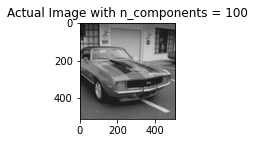

In [55]:
A_l = T.copy()
A_r = T.copy()

tic = time.time()
A_lb,U_L,V_L = Bidiagonalization(A_l)
A_rb,U_R,V_R = Bidiagonalization(A_r)
toc = time.time()
print(toc-tic)

# A_lb = gen_B(A_l,A_lb)
# A_rb = gen_B(A_r,A_rb)

tic = time.time()
u_l,s_l,v_l = QR_factorization(A_lb,U_L,V_L)
u_r,s_r,v_r = QR_factorization(A_rb,U_R,V_R)
# u_r = u_l.copy()
# s_r = s_l.copy()
# v_r = v_l.copy()
toc = time.time()
print(toc-tic)

for i in range(len(s_l)):
    s_l[i] = 1/s_l[i]
for i in range(len(s_r)):
    s_r[i] = 1/s_r[i]


# 以下calculating inverse
def pseudoinv(u,s,v,trun):
#     v=v.T
# 这一行在不掉包是删除
    A_t = v[:, :trun] @ np.diag(s[:trun]) @ u.T[:trun, :] 
    return A_t


def frobenius(X):
    return np.sqrt(np.trace(X.T @ X))

def PSNR(n,img,X_t):
    return 10*np.log10(n**2/(frobenius(X_t-img))**2)

comps = [100]
plt.figure(figsize=(12, 6))
blurry = T @ img @ T.T


for i in range(len(comps)):
    for j in range(len(comps)):
        tic = time.time()
        A_lt = pseudoinv(u_l,s_l,v_l,comps[i])
        A_rt = pseudoinv(u_r,s_r,v_r,comps[j])
        X_t = A_lt @ blurry @ A_rt
        toc = time.time()
        print(comps[i],comps[j],PSNR(img.shape[0],img,X_t),toc-tic)
    if(i == 0):
        plt.subplot(3, 6, i+1),
        plt.imshow(X_t, cmap='gray'),
        plt.title(f'Actual Image with n_components = {comps[i]}')

    else:
        plt.subplot(3, 6, i+1),
        plt.imshow(X_t, cmap='gray'),
        plt.title(f'n_components = {comps[i]}')

        
plt.show()